# Data Exploration

Setting up some basic packages for exploration.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Reading in training and testing data. Mapping salary to binary value (this is what we want to predict).

In [72]:
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("adult-data.csv")
train, test = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True)
train['income'] = train['income'].map({"<=50K":0, ">50K":1})
test['income'] = test['income'].map({"<=50K":0, ">50K":1})
# To binary mapping
train['race'] = train['race'].map({"Black": 0, "Other": 1, "Amer-Indian-Eskimo": 1, "Asian-Pac-Islander": 1, "White":1})
test['race'] = test['race'].map({"Black": 0, "Other": 1, "Amer-Indian-Eskimo": 1, "Asian-Pac-Islander": 1, "White":1})

Y = train['income']
Y_race = train['race']
X = train.drop(['income', 'fnlwgt', 'native.country', 'race'], axis = 1)
Y_test = test['income']
Y_test_race = test['race']
X_test = test.drop(['income', 'fnlwgt', 'native.country', 'race'], axis = 1)


Naive oversampling of our training data. This one of the mechanisms we will test to see its effect on bias. We simply oversample the minority class (black in this case) so that our classes are more balanced. We are going to resample based on some coefficient RESAMPLE_COEFFICIENT. If this is 1, we simple resample the total amount in the minority class. 

In [73]:
from keras.utils import to_categorical, plot_model

minority = train[train['race']== 0]
print(len(minority), len(train))
RESAMPLE_COEFFICIENT = 1.5
oversample = minority.sample(int(RESAMPLE_COEFFICIENT * len(minority)), replace = True, random_state = 1)
train_o = pd.concat([train, oversample], axis = 0)
##Perform similar X, Y split on train_o, the oversampled training data
Y_o_race = train_o['race']
Y_o = train_o['income']
X_o = train_o.drop(['income', 'fnlwgt', 'native.country', 'race'], axis = 1)

2499 26048


Some basic analysis of race groups above and below 50 K ("rich" and "poor")

In [74]:
total = train.groupby('race').size().reset_index()

rich = train[train['income'] == 1]
rich = rich.groupby('race').size().reset_index()
rich[0] = rich[0]/total[0]

poor = train[train['income'] == 0]
poor = poor.groupby('race').size().reset_index()
poor[0] = poor[0]/total[0]

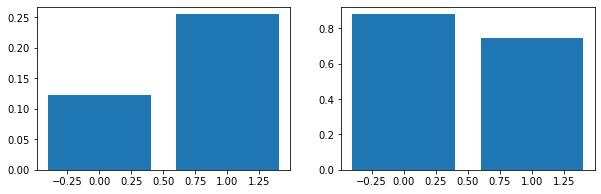

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10,3)
ax1.bar(rich['race'], rich[0])
ax2.bar(poor['race'], poor[0])
plt.show()

We want to see what is the value of $p$ in our training data, because it is likely that such a pattern will reveal itself in the model. In other words, what is the maximum bias that is shown in the data? This is assuming there are no confounding variables between race groups. 

In [76]:
#Proportion of black people who are rich. Dividing the "length" of the DFs of only >50k and the entire data, subsetting for black race
blackrich = len(rich[rich['race'] == 0])/len(train[train['race'] == 0])
#Same idea for other races
nonblackrich = len(rich[rich['race'] == 1])/len(train[train['race'] == 1])

More processing things, one-hot encoding categorical variables, making sure that the test and train have the same encodings, by using df.align on column case. Then, converting everything into numpy arrays. 

In [110]:

from keras import Sequential
from sklearn.preprocessing import OneHotEncoder

dumdf = pd.get_dummies(X, columns = ["workclass", "education", "education.num", "marital.status", "occupation", "relationship", "sex"], drop_first = True)
testdf = pd.get_dummies(X_test, columns = ["workclass", "education", "education.num", "marital.status", "occupation", "relationship", "sex"], drop_first = True)
dumdf_o = pd.get_dummies(X_o, columns = ["workclass", "education", "education.num", "marital.status", "occupation", "relationship", "sex"], drop_first =True)
dumdf,testdf = dumdf.align(testdf, join='outer', axis=1, fill_value=0)


### Simple Model

Simple neural net using nonlinear mappings and cross entropy loss function.

In [89]:

M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)


model = Model(inputs = [M1], outputs = [M3])
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ['accuracy'])
history = model.fit(dumdf,Y, batch_size = 32, epochs = 5, validation_split = 0.2, shuffle = True)


Train on 20838 samples, validate on 5210 samples
Epoch 1/5
20838/20838 [==============================] - 2s 98us/sample - loss: 4.5292 - acc: 0.8064 - val_loss: 1.6252 - val_acc: 0.8134
Epoch 2/5
20838/20838 [==============================] - 1s 69us/sample - loss: 1.0834 - acc: 0.8277 - val_loss: 1.3371 - val_acc: 0.8395
Epoch 3/5
20838/20838 [==============================] - 1s 69us/sample - loss: 1.1030 - acc: 0.8307 - val_loss: 0.9601 - val_acc: 0.8503
Epoch 4/5
20838/20838 [==============================] - 2s 74us/sample - loss: 1.1062 - acc: 0.8321 - val_loss: 1.0272 - val_acc: 0.8536
Epoch 5/5
20838/20838 [==============================] - 1s 64us/sample - loss: 1.0834 - acc: 0.8276 - val_loss: 4.0567 - val_acc: 0.8144


### Combined Loss Function

Begin ML pipeline. Setting up a basic neural network structure (which can be tinkered with later). 

The idea is we are trying to predict M3 (average income), but at the same time we want to discriminate against predicting C2 (race). 

So the rough structure looks like: M1 -> M2 -> M3 (income) -> C2 -> C3 (race)


In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)
C2 = Dense(40, activation='relu',name='C2')(M3)
C3 = Dense(1, activation='sigmoid',name='C3')(C2)

First model with adjusted loss function. Define some value $\alpha$ that represents the "discriminator" network, that punishes the loss function when the loss for C3 is smaller. $\alpha$ is an important hyperparamater to choose, though, since a large $\alpha$ may drive the network away from any good convergence, while a small $\alpha$ does little to nothing (obviously).

In [50]:
merged = Model(inputs = [M1], outputs = [M3, C3])
loss1 = 'binary_crossentropy'
loss2 = 'mse'
opt = keras.optimizers.Adam(learning_rate=0.001)
alpha = 0.1
merged.compile(optimizer = opt,loss=[loss1, loss2],loss_weights=[1, -1 * alpha], metrics=['accuracy'])
history = merged.fit(dumdf, [Y,Y_race] ,batch_size=32, epochs=5, validation_split = 0.2, shuffle = True)

Train on 20838 samples, validate on 5210 samples
Epoch 1/5
20838/20838 [==============================] - 3s 129us/sample - loss: 2.3179 - M3_loss: 2.3891 - C3_loss: 0.7397 - M3_acc: 0.8038 - C3_acc: 0.0956 - val_loss: 0.7214 - val_M3_loss: 0.8099 - val_C3_loss: 0.8863 - val_M3_acc: 0.8253 - val_C3_acc: 0.0973
Epoch 2/5
20838/20838 [==============================] - 2s 84us/sample - loss: 1.3324 - M3_loss: 1.4208 - C3_loss: 0.8987 - M3_acc: 0.8215 - C3_acc: 0.0956 - val_loss: 0.8695 - val_M3_loss: 0.9587 - val_C3_loss: 0.8996 - val_M3_acc: 0.8403 - val_C3_acc: 0.0973
Epoch 3/5
20838/20838 [==============================] - 2s 83us/sample - loss: 0.9849 - M3_loss: 1.0740 - C3_loss: 0.9024 - M3_acc: 0.8262 - C3_acc: 0.0956 - val_loss: 0.7159 - val_M3_loss: 0.8054 - val_C3_loss: 0.9014 - val_M3_acc: 0.8405 - val_C3_acc: 0.0973
Epoch 4/5
20838/20838 [==============================] - 2s 78us/sample - loss: 1.2478 - M3_loss: 1.3368 - C3_loss: 0.9038 - M3_acc: 0.8238 - C3_acc: 0.0956 - val_l

### Oversampled Model
Model with the oversampled training set, same neural network structure as the normal model though.

In [51]:
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)


Omodel = Model(inputs = [M1], outputs = [M3])
Omodel.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ['accuracy'])
history = Omodel.fit(dumdf_o,Y_o, batch_size = 32, epochs = 5, validation_split = 0.2, shuffle = True)

Train on 23836 samples, validate on 5960 samples
Epoch 1/5
23836/23836 [==============================] - 2s 87us/sample - loss: 4.3093 - acc: 0.8113 - val_loss: 0.6493 - val_acc: 0.8765
Epoch 2/5
23836/23836 [==============================] - 2s 77us/sample - loss: 1.3255 - acc: 0.8261 - val_loss: 0.5917 - val_acc: 0.8790
Epoch 3/5
23836/23836 [==============================] - 2s 67us/sample - loss: 0.8247 - acc: 0.8334 - val_loss: 0.9977 - val_acc: 0.8809
Epoch 4/5
23836/23836 [==============================] - 2s 66us/sample - loss: 1.2990 - acc: 0.8343 - val_loss: 0.4866 - val_acc: 0.8896
Epoch 5/5
23836/23836 [==============================] - 2s 67us/sample - loss: 0.6913 - acc: 0.8386 - val_loss: 0.6391 - val_acc: 0.8829


### Oversampling + Combined Loss Function

This one is supposed to combine our previous two insights. We expect this model to perform the "best" based on our ideas of debiasing. But anything is possible.

In [52]:
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)
C2 = Dense(40, activation='relu',name='C2')(M3)
C3 = Dense(1, activation='sigmoid',name='C3')(C2)

Omerged = Model(inputs = [M1], outputs = [M3, C3])
loss1 = 'binary_crossentropy'
loss2 = 'mse'
opt = keras.optimizers.Adam(learning_rate=0.001)
alpha = 0.1
Omerged.compile(optimizer = opt,loss=[loss1, loss2],loss_weights=[1, -1 * alpha], metrics=['accuracy'])
history = Omerged.fit(dumdf_o, [Y_o,Y_o_race] ,batch_size=32, epochs=5, validation_split = 0.2, shuffle = True)

Train on 23836 samples, validate on 5960 samples
Epoch 1/5
23836/23836 [==============================] - 3s 112us/sample - loss: 2.3466 - M3_loss: 2.4166 - C3_loss: 0.7041 - M3_acc: 0.8123 - C3_acc: 0.0980 - val_loss: 0.6492 - val_M3_loss: 0.6803 - val_C3_loss: 0.3312 - val_M3_acc: 0.8767 - val_C3_acc: 0.6628
Epoch 2/5
23836/23836 [==============================] - 2s 84us/sample - loss: 1.5793 - M3_loss: 1.6689 - C3_loss: 0.8958 - M3_acc: 0.8199 - C3_acc: 0.0964 - val_loss: 3.0030 - val_M3_loss: 3.0276 - val_C3_loss: 0.3372 - val_M3_acc: 0.8628 - val_C3_acc: 0.6628
Epoch 3/5
23836/23836 [==============================] - 2s 81us/sample - loss: 1.4850 - M3_loss: 1.5751 - C3_loss: 0.9015 - M3_acc: 0.8277 - C3_acc: 0.0964 - val_loss: 1.4299 - val_M3_loss: 1.4579 - val_C3_loss: 0.3360 - val_M3_acc: 0.8542 - val_C3_acc: 0.6628
Epoch 4/5
23836/23836 [==============================] - 2s 80us/sample - loss: 2.0075 - M3_loss: 2.0975 - C3_loss: 0.9027 - M3_acc: 0.8218 - C3_acc: 0.0964 - val_l

In [53]:
## Testing the models on test set
scores_merged = merged.evaluate(testdf, [Y_test, Y_test_race], batch_size=16, verbose = 0)
scores = model.evaluate(testdf, Y_test, batch_size = 16, verbose = 0)
scores_o = Omodel.evaluate(testdf, Y_test, batch_size = 16, verbose = 0)
scores_merged_o = Omerged.evaluate(testdf, [Y_test, Y_test_race], batch_size=16, verbose = 0)

In [54]:
print("Combined Loss Function Model: \nLoss: " + str(scores_merged[0]) + "\nAccuracy: " + str(scores_merged[3]))

print("Simple Model: \nLoss: " + str(scores[0]) + "\nAccuracy: " + str(scores[1]))

print("Oversampled Model: \nLoss: " + str(scores_o[0]) + "\nAccuracy: " + str(scores_o[1]))

print("Oversampling + Combined Loss Function Model: \nLoss: " + str(scores_merged_o[0]) + "\nAccuracy: " + str(scores_merged_o[3]))

Combined Loss Function Model: 
Loss: 2.4284602823518084
Accuracy: 0.8298787
Simple Model: 
Loss: 0.8953211289679933
Accuracy: 0.83724856
Oversampled Model: 
Loss: 0.6931385774958725
Accuracy: 0.84077996
Oversampling + Combined Loss Function Model: 
Loss: 0.9124806871726072
Accuracy: 0.8389375


In [60]:
accuracy_vector = [scores[1], scores_merged[3], scores_o[1], scores_merged_o[3]]

Text(0.5, 1.0, 'Accuracy in predicting income based on learning scheme')

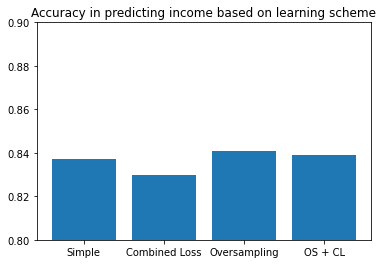

In [66]:
plt.bar(['Simple', 'Combined Loss', 'Oversampling', 'OS + CL'], accuracy_vector)
plt.ylim(0.8, 0.9)
plt.title("Accuracy in predicting income based on learning scheme")

So this is interesting. The simple model does better than the combined one, but worse than the oversampling one in terms of pure accuracy. But that's not all that matters. We ought to see which does better in diagnosing bias. To do this, we can try computing the conditional probability $P(\geq50K | black)$ on the predictions of the models.

In [116]:
def categorical_tsfm(l):
    # assert 0 < l[i] < 1
    return [1 if x > 0.5 else 0 for x in l]

# gets all indexes of a list that hit the match
def get_indexes(l, match):
    return [i for i,x in enumerate(l) if x == match]

black_index = get_indexes(Y_test_race, 0)
num_black = len(Y_test_race[Y_test_race ==0])

#Simple Model
result = model.predict(testdf)
result = categorical_tsfm(result)
result_index = get_indexes(result, 1)
shared = list(set(black_index) & set(result_index))
P_simple = len(shared)/num_black

#Combined Model
result = list(merged.predict(testdf)[0])
result = categorical_tsfm(result)
result_index = get_indexes(result, 1)
shared= list(set(black_index) & set(result_index))
P_merged = len(shared)/num_black

#Oversampled Model
result = Omodel.predict(testdf)
result = categorical_tsfm(result)
result_index = get_indexes(result, 1)
shared = list(set(black_index) & set(result_index))
P_over = len(shared)/num_black

#Oversample + combined Model
result = list(Omerged.predict(testdf)[0])
result = categorical_tsfm(result)
result_index = get_indexes(result, 1)
shared = list(set(black_index) & set(result_index))
P_over_merged = len(shared)/num_black


0.0832

<BarContainer object of 4 artists>

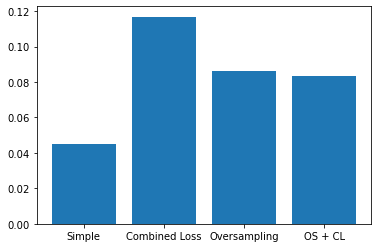

In [117]:
plt.bar(['Simple', 'Combined Loss', 'Oversampling', 'OS + CL'], [P_simple, P_merged, P_over, P_over_merged])